In [1]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from source.models.hidfmux.hidfmux_timestream import TimestreamData
from source.services.hidfmux_pkl_file_load_service import HidfmuxFileLoadService
from source.models.hidfmux.hidfmux_multi_sweep import HidfmuxMultiSweep
from source.util import noise_multiplication_method_tools
from source.models.noise.noise_sweep import NoiseSweep
from source.models.hidfmux.hidfmux_timestream import HidfmuxTimestream
from source.util import hidfmux_data_tools 
from source.util import hidfmux_transfer_functions
from netCDF4 import Dataset

from scipy.interpolate import CubicSpline



# Objectives:

1. Check the quality of the timestream data by plotting timestream IQ on the corresponding multisweep IQ circle.

In [2]:
multi_sweep_path = r"/export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/hidfmux_output/20240226/20240226_130453_multisweep/iceboard0147_rmod1/bias_find_multisweep_ampVARIOUS_npts150.pkl"
timestream_path = r"/export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/ts/slim_20_3_scan01.nc"
picked_tones_file = r"/export/samba/Data/spt-slim/slim20/submodule/20240308_uc_fts/hidfmux_output/20240228/20240228_163848_multisweep/iceboard0147_rmod1/picked_tones.npy"
dut = "slim20_v2_anl_channel_1"


In [3]:
multisweep_dictionary = np.load(
    multi_sweep_path,
    mmap_mode=None,
    allow_pickle=True,
    fix_imports=True,
    encoding="ASCII",
)

In [4]:
# Get best bias amplitudes and tone_names:
tone_name_array = np.array(multisweep_dictionary["info"]["name_list"])
(
    best_bias_amplitudes,
    bias_frequencies,
    no_bifurcation_tones
) = hidfmux_data_tools.get_best_multisweep_bias(multisweep_dictionary)
best_bias_indices = hidfmux_data_tools.get_best_bias_data_indices(
    bias_multisweep=multisweep_dictionary,
    best_bias_amplitudes=best_bias_amplitudes
)


In [5]:
# load multisweep using the best bias indices.
multisweep = HidfmuxFileLoadService.load_pkl_multi_sweep_file(multi_sweep_path, sweep_index=best_bias_indices)

In [6]:
# Get list of the tones names that were used in measurements and their bias frequencies.
picked_tones_dict = np.load(picked_tones_file, allow_pickle=True).tolist()
picked_tones = np.array([*picked_tones_dict.keys()])
picked_tone_frequencies = []
for tone in picked_tones:
    picked_tone_frequencies.append(picked_tones_dict[tone])

# Create kid quality array from the used tones
new_kid_quality_array = np.full(tone_name_array.shape, fill_value=False, dtype=bool)
picked_tone_name_indices = np.where(np.in1d(tone_name_array, picked_tones))[0]
new_kid_quality_array[picked_tone_name_indices] = True

picked_tone_amp_indices = best_bias_indices[picked_tone_name_indices]

In [7]:
picked_tones = multisweep.tone_name_array
picked_tone_frequencies = bias_frequencies
picked_tone_amp_indices = best_bias_indices

In [8]:
# Plot the used (Green) and not used (red) tones: 
# multisweep.plot_good_kids(kid_quality_array=new_kid_quality_array)

In [9]:
timestream_data = Dataset(timestream_path,'r')


In [10]:
#this calculates the total phase shift by which you need to multiply raw timestream data
#you have to do this or df will be garbage
#that tone better be within the sweep
def get_phase_correction_from_sweep(sdict, kid, latency, tone, amp_index=0):
	"""
	Description:

	ARGUMENTS
	---------


	RETURNS
	-------


	TODO
	----
	
	"""
	iq_adc = sdict['data'][kid][amp_index]['iq_raw']
	iq_cal = sdict['data'][kid][amp_index]['cal_iq']
	phi_internal = np.angle(iq_adc) - np.angle(iq_cal)

	freq = sdict['data'][kid][0]['freq']
	phi_latency = np.asarray([np.pi*(1. - (2*latency)*(f%(1./latency))) for f in freq])

	neg_phi_fpga = phi_internal - phi_latency

	#interpolate over the sweep (phase vs freq)
	interp_phase = CubicSpline(freq, neg_phi_fpga%(2*np.pi))
	neg_phase_correction = interp_phase(tone)
	return neg_phase_correction

In [11]:
#apply a phase correction to a raw timestream and also divide it by any data-packet-related constant
def correct_timestream_phase(iq_ts, neg_phase_correction, ts_mult_factor=1./256):
	"""
	Description:

	ARGUMENTS
	---------


	RETURNS
	-------


	TODO
	----
	
	"""
	iq_corr = np.abs(iq_ts*ts_mult_factor)*(np.cos(neg_phase_correction)+1.j*np.sin(neg_phase_correction))
	return iq_corr	

In [12]:
timestreams_array = np.empty(
    shape=picked_tones[:8].shape, dtype=object
)
bias_power_array = np.empty(
    shape=picked_tones[:8].shape, dtype=float,
)
sweep_data_array = np.empty(
    shape=picked_tones[:8].shape, dtype=object
)

for count, tone in enumerate(picked_tones[:8]):
    kid_i_raw = timestream_data.variables[tone+'_I'][:]
    kid_q_raw = timestream_data.variables[tone+'_Q'][:]

    kid_iq_raw = kid_i_raw+1j*kid_q_raw

    tone_frequency = picked_tone_frequencies[count]
# 
    tone_bias_power = multisweep.get_tone_bias_power(
        tone=tone,
        db=False
    )
    # Get tone calibration sweep data to calibrate timestream IQ
    sweep_data = multisweep.get_tone_sweep_data(
        tone=tone
    )
    calibration_iq_array = multisweep.get_tone_calibration_iq_data(
        tone=tone
    )

    neg_phase_correction = get_phase_correction_from_sweep(
        sdict=multisweep_dictionary,
        kid=tone,
        tone=tone_frequency,
        latency=hidfmux_transfer_functions.DEMOD_SAMPLING_FREQ,
        amp_index=picked_tone_amp_indices[count]
    )

    kid_iq = correct_timestream_phase(kid_iq_raw, neg_phase_correction, ts_mult_factor=1)
    kid_i = np.real(kid_iq[15:]) # killing the first point which can be a very different value
    kid_q = np.imag(kid_iq[15:])

    time_array = np.array(timestream_data.variables["Time"][:])

    timestream = TimestreamData(
        n_timestreams=1,
        sample_rate=hidfmux_transfer_functions.DEMOD_SAMPLING_FREQ,
        measurement_length=time_array[-1] - time_array[0],
        tone_frequency=tone_frequency,
        timestream_i_data=kid_i,
        timestream_q_data=kid_q,
        timestream_time_data=time_array,
    )

    timestreams_array[count] = timestream
    bias_power_array[count] = tone_bias_power
    sweep_data_array[count] = sweep_data
    
    print(f"Tone {tone} Processed ({count + 1 }/{picked_tones[:8].size})")


test_hidfmux_timestream = HidfmuxTimestream(
    bias_power_array=bias_power_array,
    tone_name_array=picked_tones[:8],
    sweep_data_array=sweep_data_array,
    on_res_timestreams_array=timestreams_array,
    off_res_timestreams_array=timestreams_array,
)

Tone 0000 Processed (1/8)
Tone 0001 Processed (2/8)
Tone 0002 Processed (3/8)
Tone 0003 Processed (4/8)
Tone 0004 Processed (5/8)
Tone 0005 Processed (6/8)
Tone 0006 Processed (7/8)
Tone 0007 Processed (8/8)


sweep: 1.123E-03
TS: 1.100E-03
sweep: 1.990E-03
TS: -1.586E-03
sweep: -7.793E-04
TS: 1.028E-03
sweep: -1.989E-03
TS: 1.498E-03
sweep: 4.178E-04
TS: 1.297E-03
sweep: 7.708E-04
TS: -1.127E-03
sweep: 9.255E-04
TS: 2.644E-04
sweep: 1.695E-03
TS: 2.086E-03


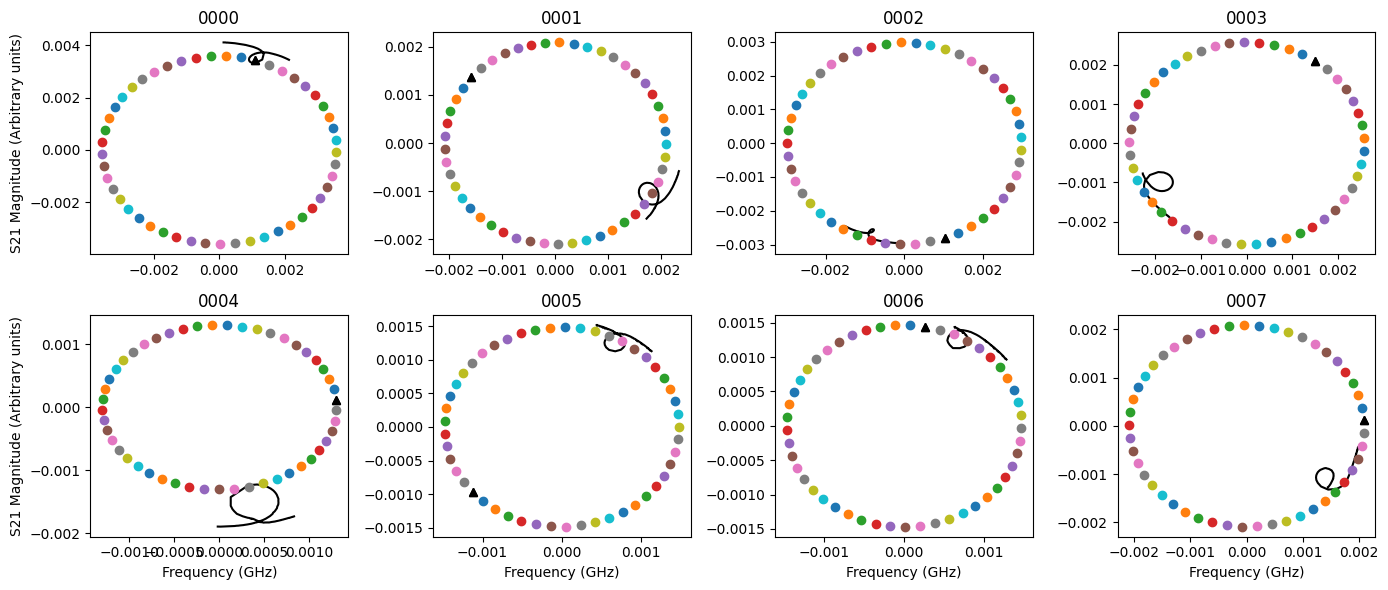

In [13]:
every_nth_value = 30000

# n_sweeps = hidfmux_timestream.tone_name_array.shape[0]
n_sweeps = 8
n_columns = 4
n_rows = math.ceil(n_sweeps / n_columns)

row = 0
column = 0
figures, axes = plt.subplots(n_rows, n_columns, figsize=(14, n_rows * 3))
for count, sweep in enumerate(test_hidfmux_timestream.sweep_data_array[:8]):
    current_timestream = test_hidfmux_timestream.get_tone_timestream_data(
        tone=test_hidfmux_timestream.tone_name_array[count],
        on_res=True
    )
    current_i = current_timestream.timestream_i_data * hidfmux_transfer_functions.VOLTS_PER_ROC
    current_q = current_timestream.timestream_q_data * hidfmux_transfer_functions.VOLTS_PER_ROC

    print(f"sweep: {np.mean(sweep.i):.3E}")
    print(f"TS: {np.mean(current_i):.3E}")
    axes[row][column].plot(
        sweep.i, sweep.q, color="k"
    )

    rot_angle_array = np.linspace(0, 2, 50)

    # rot_angle_array = np.array([2])

    for angle in rot_angle_array:
        i = np.mean(current_i)
        q = np.mean(current_q)
        current_iq = (i + 1j*q) * np.exp(1.0j*np.pi*angle)
        i = current_iq.real
        q = current_iq.imag

        if angle == 0.0 or angle == 2.0:
            axes[row][column].plot(
                i,
                q,
                linestyle="none",
                marker="^",
                color="k",
            )
        else:
            axes[row][column].plot(
                    i,
                    q,
                    linestyle="none",
                    marker="o",
            )
    axes[row][column].set_title(
        test_hidfmux_timestream.tone_name_array[count]
    )

    if column == 0:
        axes[row][column].set_ylabel("S21 Magnitude (Arbitrary units)")

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Frequency (GHz)")

    column += 1
    if column == 4:
        column = 0
        row += 1
plt.tight_layout()
plt.show()

In [14]:
current_timestream = test_hidfmux_timestream.get_tone_timestream_data(
        tone=test_hidfmux_timestream.tone_name_array[0],
        on_res=True
    )

In [15]:
current_timestream.timestream_i_data.size / 30000

9.0633